In [5]:
%load_ext autoreload
%autoreload 2
import pickle as pkl
import warnings

import auggam
import matplotlib.pyplot as plt
import numpy as np
import torch
import transformers
from tqdm import tqdm
from auggam import data
from sklearn.base import ClassifierMixin, RegressorMixin

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import dvu
dvu.set_style()
sys.path.append('../results')
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def sparse_predict(model, X, warn, frac_ngrams=1):
    """Predict only the cached coefs in self.coefs_dict_"""
    assert hasattr(model, "coefs_dict_"), "coefs are not cached!"
    preds = []
    n_unseen_ngrams = 0
    for x in X:
        pred_list = []
        seqs = auggam.embed.generate_ngrams_list(
            x,
            ngrams=model.ngrams,
            tokenizer_ngrams=model.tokenizer_ngrams,
            all_ngrams=model.all_ngrams,
        )

        for seq in seqs:
            if seq in model.coefs_dict_:
                pred_list.append(model.coefs_dict_[seq])
            else:
                n_unseen_ngrams += 1

        def key(x):
            if type(x) is np.ndarray:
                return sum(abs(x))
            return abs(x)

        pred_arr = np.array(sorted(pred_list, key=key, reverse=True))

        if len(pred_arr) == 0:
            preds.append(0)
        elif frac_ngrams < 1:
            # only look at a fraction of seqs
            if pred_arr.ndim == 1:
                cumsum = np.cumsum(np.abs(pred_arr))
            elif pred_arr.ndim == 2:
                cumsum = np.cumsum(np.sum(np.abs(pred_arr), axis=1))

            # note cumsum[-1] is the total sum of absolute value of all the elements
            idx = np.where((cumsum / cumsum[-1]) > frac_ngrams)[0][0]
            preds.append(sum(pred_arr[: idx + 1]))
        else:
            preds.append(sum(pred_arr))

    if n_unseen_ngrams > 0 and warn:
        warnings.warn(
            f"Saw an unseen ungram {n_unseen_ngrams} times. \
For better performance, call cache_linear_coefs on the test dataset \
before calling predict."
        )

    preds = np.array(preds)
    if isinstance(model, RegressorMixin):
        return preds
    elif isinstance(model, ClassifierMixin):
        if preds.ndim > 1:
            return np.argmax(preds, axis=1)
        return ((preds + model.linear.intercept_) > 0).astype(int)

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
dsets = {
    "financial_phrasebank": "ahmedrachid/FinancialBERT-Sentiment-Analysis",  # 3 class classification
    "sst2": "textattack/bert-base-uncased-SST-2",
    "emotion": "nateraw/bert-base-uncased-emotion",  # 6 class classification
    "rotten_tomatoes": "textattack/bert-base-uncased-rotten_tomatoes",
}
DSETS_RENAME_DICT = {
    'emotion': 'Emotion',
    'sst2': 'SST2',
    'tweet_eval': 'Tweet (Hate)',
    'rotten_tomatoes': 'Rotten tomatoes',
    'financial_phrasebank': 'Financial phrasebank',
}

In [8]:
acc_vals = {}
frac_ngrams = np.linspace(1, 100, num=100) / 100

for dataset in dsets.keys():
    checkpoint = dsets[dataset]

    # set up data
    dset, dataset_key_text = data.process_data_and_args(dataset)
    dset_train = dset["train"]
    dset_val = dset["validation"]

    # load model
    with open(f"../results/4gram_{dataset}_imodelsx.pkl", "rb") as f:
        m = pkl.load(f)

    # predict
    m.cache_linear_coefs(dset_val[dataset_key_text])

    transformer_model = transformers.AutoModel.from_pretrained(m.checkpoint).to(
        DEVICE
    )
    tokenizer_embeddings = transformers.AutoTokenizer.from_pretrained(m.checkpoint)

    # generate plot
    dataset_acc = []
    for frac in tqdm(frac_ngrams):
        preds = sparse_predict(
            m, dset_val[dataset_key_text], True, frac_ngrams=frac
        )
        dataset_acc.append(np.mean(preds == dset_val["label"]))

    acc_vals[dataset] = dataset_acc

Found cached dataset financial_phrasebank (/home/chansingh/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)
Some weights of the model checkpoint at ahmedrachid/FinancialBERT-Sentiment-Analysis were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Nothing to update!


Some weights of the model checkpoint at ahmedrachid/FinancialBERT-Sentiment-Analysis were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 100/100 [00:50<00:00,  1.97it/s]
Using custom data configuration default
Found cached dataset sst2 (/home/chansingh/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at textattack/bert-base-uncased-SST-2 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Nothing to update!


Some weights of the model checkpoint at textattack/bert-base-uncased-SST-2 were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


No config specified, defaulting to: emotion/split


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /home/chansingh/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at nateraw/bert-base-uncased-emotion were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Nothing to update!


Some weights of the model checkpoint at nateraw/bert-base-uncased-emotion were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 100/100 [01:17<00:00,  1.29it/s]
Using custom data configuration default
Found cached dataset rotten_tomatoes (/home/chansingh/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at textattack/bert-base-uncased-rotten_tomatoes were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


	Nothing to update!


Some weights of the model checkpoint at textattack/bert-base-uncased-rotten_tomatoes were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


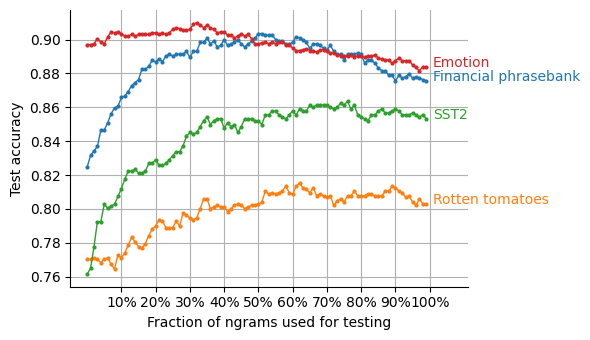

In [17]:
plt.figure(figsize=(6, 3.5))
dsets
dsets_plot = ['financial_phrasebank', 'rotten_tomatoes', 'sst2', 'emotion']
for i, dset in enumerate(dsets_plot):
    plt.plot(acc_vals[dset], '.-', label=DSETS_RENAME_DICT[dset], lw=1, ms=4)
plt.grid()
plt.xticks(list(range(10,110,10)), [f'{n + 1}0%' for n in range(10)])
plt.ylabel('Test accuracy')
plt.xlabel('Fraction of ngrams used for testing')
dvu.line_legend(fontsize='medium')
plt.tight_layout()
plt.savefig('vary_sparsity.pdf', bbox_inches='tight')
plt.show()